In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1: Load and Merge the Dataset

In [2]:
true_news_df = pd.read_csv('../data/raw/True.csv')
fake_new_df = pd.read_csv('../data/raw/Fake.csv')

In [3]:
true_news_df['label'] =0 # True News
fake_new_df['label'] = 1 # Fake News

# Combine
df = pd.concat([fake_new_df, true_news_df]).sample(frac=1, random_state=42).reset_index(drop=True)

## 2: Inspecting the Raw Data

In [4]:
df.shape

(44898, 5)

In [5]:
df.sample(10)

,title,text,subject,date,label
44698,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,left-news,"Mar 31, 2015",1
23418,Tucker Carlson to Border Angels Founder: Why S...,21st Century Wire says Why shouldn t borders b...,Middle-east,"January 25, 2017",1
40677,"Live From New York, It’s Donald Trump: SNL And...",The show went on last night even though protes...,politics,"Nov 8, 2015",1
38637,Hillary’s Latest One Word Response To Trump O...,With the race for president getting hotter by ...,News,"June 17, 2016",1
23682,Saudi King Salman says determined to confront ...,RIYADH (Reuters) - Saudi Arabia s King Salman ...,worldnews,"December 13, 2017",0
31311,WATCH: Morning Joe Knows Trump Bribed Pam Bon...,The Morning Joe panel just NAILED Donald Trump...,News,"September 7, 2016",1
13490,Japan's Dentsu gets only small fine for overti...,TOKYO (Reuters) - Japan s Dentsu Inc was fined...,worldnews,"October 6, 2017",0
4485,"JULIAN ASSANGE GETS EMOTIONAL Over His Family,...",I know what I m doing. I m prepared to wear t...,politics,"Jan 4, 2017",1
16968,BREAKING: DALLAS SNIPER SUSPECT Reportedly Tel...,If this sniper is part of the Black Lives Matt...,left-news,"Jul 8, 2016",1
14329,Ana Navarro Unleashes EPIC Tweetstorm Explain...,All kinds of people from both the Left and the...,News,"November 14, 2016",1


In [6]:
df.describe(include='all')


,title,text,subject,date,label
count,44898,44898,44898,44898,44898.000000
unique,38729,38646,8,2397,NaN
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",NaN
freq,14,627,11272,182,NaN
mean,NaN,NaN,NaN,NaN,0.522985
std,NaN,NaN,NaN,NaN,0.499477
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,1.000000


### 2.1: Checking For Null Values

In [7]:
df.info()
print("\n Null Values \n",df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB

 Null Values 
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


<div style=" border-left: 4px solid #007acc; padding: 16px; margin-bottom: 12px;">

**Data Quality Check:**  
There are no missing values in the dataset.  
Next, let's examine if there are any duplicate rows present.

</div>

### 2.2: Checking for Duplicates

Fully duplicated rows: 405


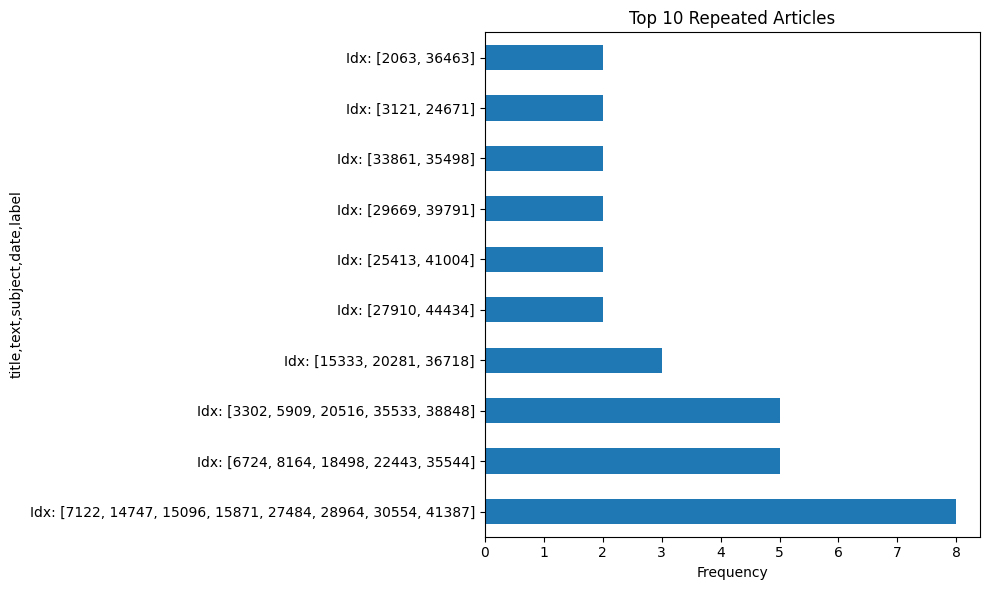

In [8]:
# Detect fully duplicated rows
full_duplicates = df[df.duplicated(keep=False)]

print(f"Fully duplicated rows: {full_duplicates.shape[0]}")

# Visualize top repeated articles with their indices
top_duplicates = full_duplicates.value_counts().head(10)
top_indices = [full_duplicates[(full_duplicates == row).all(axis=1)].index.tolist() for row in top_duplicates.index]
labels = [f"Idx: {inds}" for inds in top_indices]

top_duplicates.plot(kind='barh', figsize=(10,6), title='Top 10 Repeated Articles')
plt.xlabel("Frequency")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.tight_layout()
plt.show()


In [9]:
# Duplicate based only on 'text' column
text_duplicates = df[df.duplicated(subset='text', keep=False)]

print(f"Articles with duplicated text: {text_duplicates.shape[0]}")

# Optional: Show label disagreement on same text
label_conflict = text_duplicates.groupby('text')['label'].nunique()
conflicts = label_conflict[label_conflict > 1]
print(f"Texts with conflicting labels: {conflicts.shape[0]}")


Articles with duplicated text: 11392
Texts with conflicting labels: 1


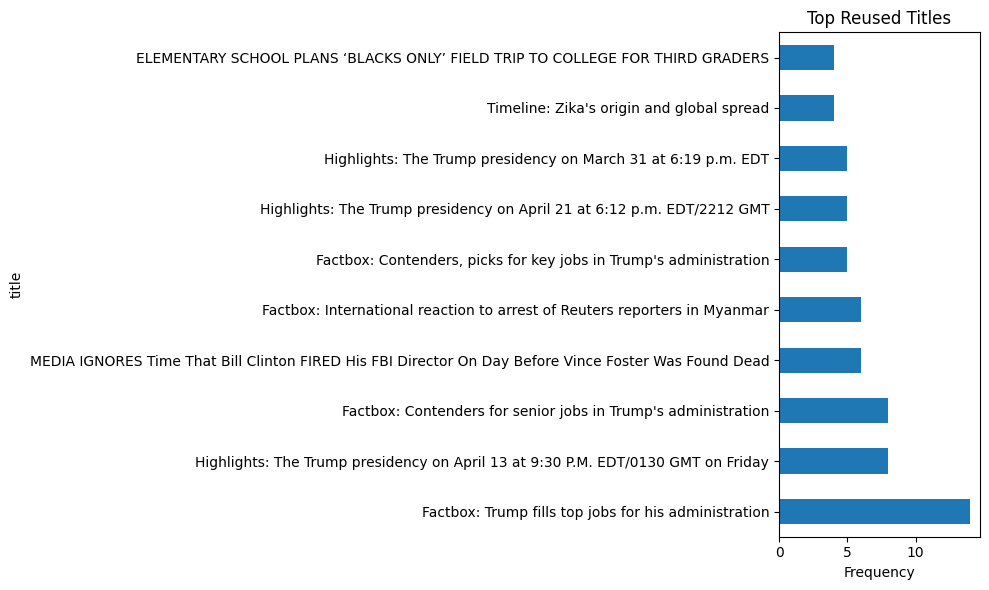

In [10]:
title_dupes = df[df.duplicated(subset='title', keep=False)]

# Top reused titles
top_titles = title_dupes['title'].value_counts().head(10)
top_titles.plot(kind='barh', figsize=(10,6), title='Top Reused Titles')
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()



###  **Duplicate Handling Summary**

1. **Remove Fully Identical Rows**  
   - Eliminated rows that are exact duplicates across *all* columns to remove redundant data.

2. **Remove Duplicate Entries with Same Text and Label**  
   - For entries with identical `'text'` and `'label'`, kept only the most recent based on `'date'`.  
   - This preserves cases where the same text is labeled differently, avoiding accidental data loss and maintaining label diversity.

3. **Remove Conflicting Labels on Same Text**  
   - Identified texts that have multiple differing labels and removed all such entries to ensure label consistency and prevent model confusion.

---
###  **Outcome**

- Dataset redundancy is reduced while preserving meaningful variations in labeling.  
- Label conflicts are eliminated, improving dataset quality for more reliable model training.  
- The cleaning pipeline strikes a balance between data quantity and data integrity.


In [11]:
# Backup original dataset
df_original = df.copy()

# STEP 1: Drop fully identical rows
df_step1 = df.drop_duplicates()
removed_full_duplicates = df_original.shape[0] - df_step1.shape[0]
print(f"Step 1 - Removed fully duplicated rows: {removed_full_duplicates}")

# STEP 2: Remove duplicates where both 'text' and 'label' are the same, keep latest by 'date'
df_step1.loc[:, 'date'] = pd.to_datetime(df_step1['date'], errors='coerce')
df_step2 = df_step1.sort_values('date').drop_duplicates(subset=['text', 'label'], keep='last')
removed_text_label_duplicates = df_step1.shape[0] - df_step2.shape[0]
print(f"Step 2 - Removed duplicates with same 'text' and 'label' (kept latest): {removed_text_label_duplicates}")

# STEP 3: Remove entries with conflicting labels for the same 'text'
label_conflicts = df_step2.groupby('text')['label'].nunique()
conflicted_texts = label_conflicts[label_conflicts > 1].index
df_final = df_step2[~df_step2['text'].isin(conflicted_texts)]
removed_label_conflicts = df_step2.shape[0] - df_final.shape[0]
print(f"Step 3 - Removed entries with conflicting labels on same text: {removed_label_conflicts}")

# FINAL SUMMARY
total_removed = removed_full_duplicates + removed_text_label_duplicates + removed_label_conflicts
print(f"\n Total records removed after all steps: {total_removed}")
print(f" Final dataset shape: {df_final.shape}")


Step 1 - Removed fully duplicated rows: 209
Step 2 - Removed duplicates with same 'text' and 'label' (kept latest): 6042
Step 3 - Removed entries with conflicting labels on same text: 2

 Total records removed after all steps: 6253
 Final dataset shape: (38645, 5)


## 3: Analyzing the class balance

Class counts:
label
0    21191
1    17454
Name: count, dtype: int64


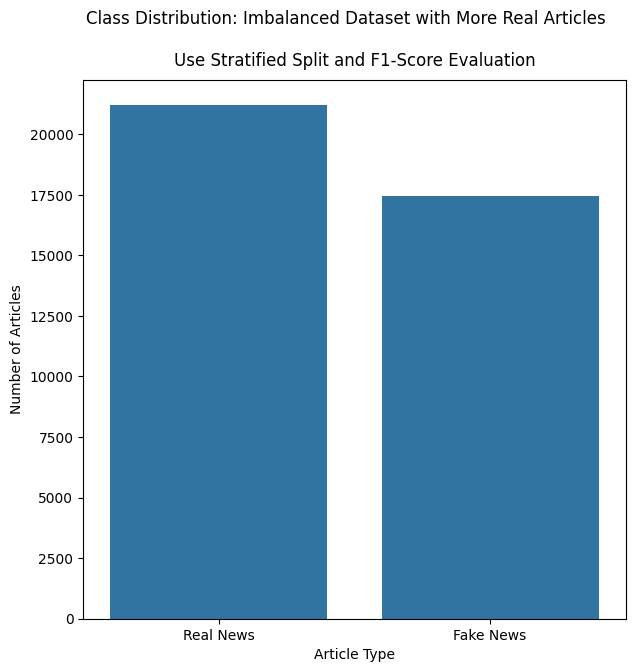

In [12]:
# Count number of samples per label
class_counts = df_final['label'].value_counts()

print("Class counts:")
print(class_counts)

# Map label values to meaningful names
label_names = {0: 'Real News', 1: 'Fake News'}

# Plot class distribution with labeled x-ticks
plt.figure(figsize=(7,7))
sns.barplot(x=[label_names[i] for i in class_counts.index], y=class_counts.values)
plt.suptitle("Class Distribution: Imbalanced Dataset with More Real Articles\n", fontsize=12)
plt.title("Use Stratified Split and F1-Score Evaluation", pad=10)
plt.xlabel("Article Type")
plt.ylabel("Number of Articles")
plt.xticks(rotation=0)
plt.show()


## 4: Create Metadata Features

In [16]:
df_final.loc[:,'text_length']  = df_final['text'].apply(lambda x: len(x))
df_final.loc[:,'title_length'] = df_final['title'].apply(lambda x: len(x))
df_final.loc[:,'exclamations_mark_count'] = df_final['text'].str.count('!')
df_final.loc[:,'questions_mark_count'] = df_final['text'].str.count(r'\?')
df_final.loc[:,'uppercase_words_count'] = df_final['text'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))
df_final.loc[:,'date'] = pd.to_datetime(df_final['date'], errors='coerce')
df_final.loc[:,'day_of_week'] = df_final['date'].dt.day_name()

###  **Purpose of Metadata Features**

1. **Article and Title Length**

   * To analyze structural differences in how fake vs. real news is written (e.g., short/snappy or lengthy articles).

2. **Punctuation Counts (!, ?)**

   * To detect sensational or emotionally charged writing, which is common in misleading content.

3. **All Uppercase Word Count**

   * To identify use of shouting or attention-grabbing language — a common trait in fake headlines.

4. **Day of Week from Date**

   * To uncover publishing patterns or timing trends in fake vs. real articles (e.g., more fake news on weekends).

5. **Subject Extraction**

   * To explore if certain topics are more prone to misinformation.




In [18]:
df_final.head(10)

,title,text,subject,date,label,text_length,title_length,exclamations_mark_count,questions_mark_count,uppercase_words_count,day_of_week
126,(VIDEO) SICKENING CHALLENGE GOES VIRAL: DISRES...,"A sick new challenge is going viral, urging ...",left-news,2015-05-01,1,1503,89,0,0,5,Friday
19033,CLINTON CHARITIES RAKED IN TAXPAYER DOLLARS IN...,This is like one big slush fund for Hillary 20...,left-news,2015-05-01,1,2886,59,1,0,18,Friday
22459,(VIDEO) MADNESS IN THE STREETS: OVER 100 COPS ...,Bill O Reilly isn t my favorite and can be bel...,politics,2015-05-01,1,3950,97,2,3,16,Friday
41528,BALTIMORE POLICE UNION WANTS AN INDEPENDANT PR...,The Police Union came out almost immediately a...,left-news,2015-05-01,1,1440,100,0,0,2,Friday
43596,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,Marilyn Mosby held a press conference today in...,left-news,2015-05-01,1,245,93,0,0,0,Friday
30194,(VIDEO) ALAN DERSHOWITZ – SAD DAY FOR JUSTICE ...,You re At Forefront Of This Cause And As Youn...,politics,2015-05-01,1,92,111,0,0,2,Friday
40979,OBAMACARE TAKING DOWN MORE RURAL HOSPITALS,Let s face it Obamacare s been a disaster from...,Government News,2015-05-02,1,3347,42,1,4,8,Saturday
28036,PRO-ABORTION BOOK FOR CHILDREN: My “Sister Is ...,Leftist indoctrination for toddlers How I wish...,left-news,2015-05-02,1,2687,61,6,2,5,Saturday
33539,FROM THE RELIGION OF PEACE: ISIS Babies…A Whol...,The future of jihad appears to be alive and we...,politics,2015-05-04,1,666,85,0,0,3,Monday
40532,BREAKING: BALTIMORE GOT BUCKET LOADS OF MONEY ...,Holy smokes! That s billion with a B! Where di...,Government News,2015-05-04,1,2451,102,3,1,9,Monday


## 5: Performing Visual Explorations

### 5.1: Which subject has more fake new?

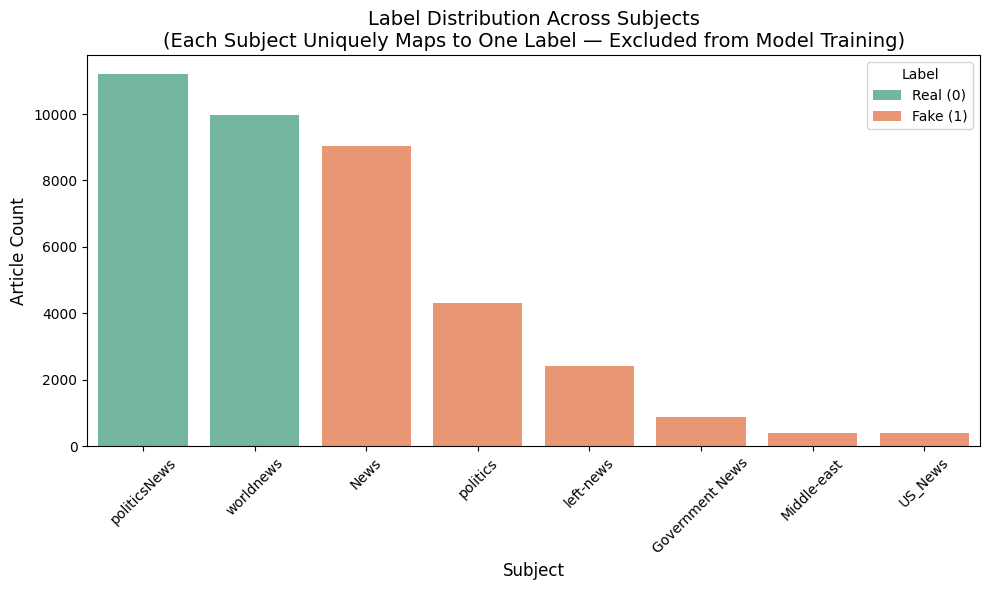

In [39]:
plt.figure(figsize=(10,6))

sns.countplot(
    data=df_final, 
    x='subject', 
    hue='label', 
    order=df_final['subject'].value_counts().index,
    palette='Set2'
)

# Main title and subtitle with reasoning
plt.title(
    "Label Distribution Across Subjects\n(Each Subject Uniquely Maps to One Label — Excluded from Model Training)",
    fontsize=14
)

plt.xlabel("Subject", fontsize=12)
plt.ylabel("Article Count", fontsize=12)
plt.xticks(rotation=45)

# Legend
plt.legend(title='Label', labels=['Real (0)', 'Fake (1)'])

plt.tight_layout()
plt.show()


###  Summary of the subject column

> We observed that the `subject` column is perfectly aligned with the target `label`. Categories like `'left-news'`, `'politics'`, etc. contain only fake news, while `'worldnews'` and `'politicsNews'` contain only real news. This introduces a strong risk of **data leakage**, and therefore, we chose to exclude the `subject` feature from model training. It may still be used for exploratory analysis.




In [21]:
df_final.subject.unique()

array(['left-news', 'politics', 'Government News', 'News', 'US_News',
       'Middle-east', 'politicsNews', 'worldnews'], dtype=object)

### 5.2 How does the distribution of title_length varies accross different labels?

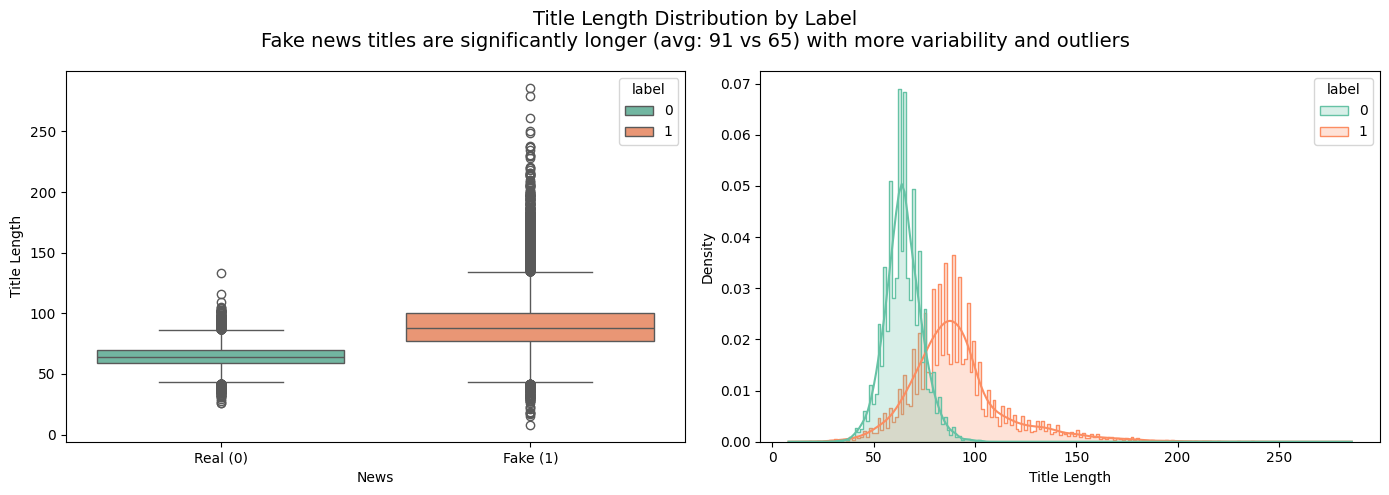

In [65]:
# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
plt.suptitle(
    "Title Length Distribution by Label\n"
    "Fake news titles are significantly longer (avg: 91 vs 65) with more variability and outliers",
    fontsize=14
)
# --- Box Plot ---
sns.boxplot(data=df_final, x='label', y='title_length', ax=axes[0], palette='Set2', hue='label')
# Use set_xticks to ensure correct tick positions before setting labels
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Real (0)', 'Fake (1)'])
axes[0].set_xlabel("News")
axes[0].set_ylabel("Title Length")

# --- Histogram / KDE ---
sns.histplot(data=df_final, x='title_length', hue='label', kde=True, ax=axes[1],
             element='step', stat='density', common_norm=False, palette='Set2')
axes[1].set_xlabel("Title Length")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

In [58]:
print(df_final.groupby('label')['title_length'].describe())

         count       mean        std   min   25%   50%    75%    max
label                                                               
0      21191.0  64.661177   9.158737  26.0  59.0  64.0   70.0  133.0
1      17454.0  91.221611  24.518767   8.0  77.0  88.0  100.0  286.0



###  Summary: Title Length vs. News Label

* **Fake news titles** are, on average, **significantly longer** than real news titles (91 vs. 65 characters).
* They also show **greater variability** (std: 24.5 vs. 9.1) and more **extreme outliers**, reaching up to 286 characters.
* In contrast, **real news titles** are more consistent in length and tightly clustered around the median.
* This suggests that **sensational or verbose headlines** may be a distinguishing trait of fake news articles.



### 5.2 How does the distribution of text_length varies accross different labels?

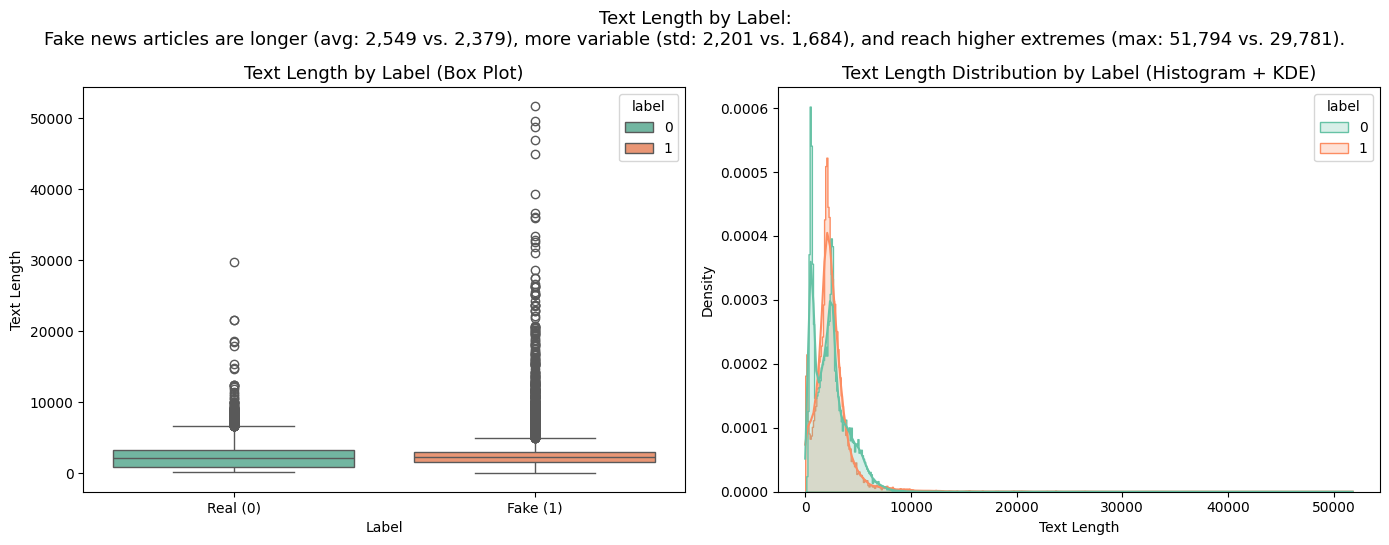

In [71]:



# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- Box Plot for text_length ---
sns.boxplot(data=df_final, x='label', y='text_length', ax=axes[0], palette='Set2', hue='label')
axes[0].set_title('Text Length by Label (Box Plot)', fontsize=13)
axes[0].set_xticks([0,1])
axes[0].set_xticklabels(['Real (0)', 'Fake (1)'])
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Text Length")

# --- Histogram + KDE for text_length ---
sns.histplot(data=df_final, x='text_length', hue='label', kde=True, ax=axes[1],
             element='step', stat='density', common_norm=False, palette='Set2')
axes[1].set_title('Text Length Distribution by Label (Histogram + KDE)', fontsize=13)
axes[1].set_xlabel("Text Length")
axes[1].set_ylabel("Density")

plt.tight_layout()
# Add a concise, informative suptitle

plt.suptitle(
    "Text Length by Label:\n"
    "Fake news articles are longer (avg: 2,549 vs. 2,379), more variable (std: 2,201 vs. 1,684), and reach higher extremes (max: 51,794 vs. 29,781).",
    fontsize=13, y=1.08
)

plt.show()


In [67]:
print(df_final.groupby('label')['text_length'].describe())


         count         mean          std    min     25%     50%      75%  \
label                                                                      
0      21191.0  2378.527158  1683.781664  152.0   906.5  2216.0  3226.50   
1      17454.0  2549.953019  2201.306830    2.0  1649.0  2235.0  3005.75   

           max  
label           
0      29781.0  
1      51794.0  


###  Summary: Text Length vs. News Label

* **Fake news articles** (label = 1) have **slightly longer average text length** (2,549 vs. 2,379 characters for real news).
* They exhibit **greater variability** (std: 2,201 vs. 1,684), with extreme lengths reaching up to 51,794 characters for fake articles and 29,781 for real.
* **Real news** (label = 0) is more consistent, with articles typically ranging between 900 and 3,226 characters.
* The **wider distribution and higher max values** in fake news suggest that these articles are more likely to contain longer, verbose content.


